### Sediment Temperature

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/fitur_clean/density.csv')

In [4]:
df.isna().sum()

measurement_id                                     0
depth_reading_time                                 0
water_temperature_50m                              0
salinity_50m                                       0
oxygen_saturation_50m                           4237
perceived_water_density                            0
sediment_deposition                             7131
seafloor_pressure                               4433
plankton_density                                   0
microplankton_density                              0
mesoplankton_density                               0
macroplankton_density                              0
dissolved_gas_pressure                             0
current_velocity_near_surface                      0
current_velocity_deep                              0
current_direction_near_surface                     0
current_direction_deep                             0
current_turbulence                                 0
sediment_temperature_0_to_10cm                

In [5]:
# Convert date column to datetime
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'])

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr('spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

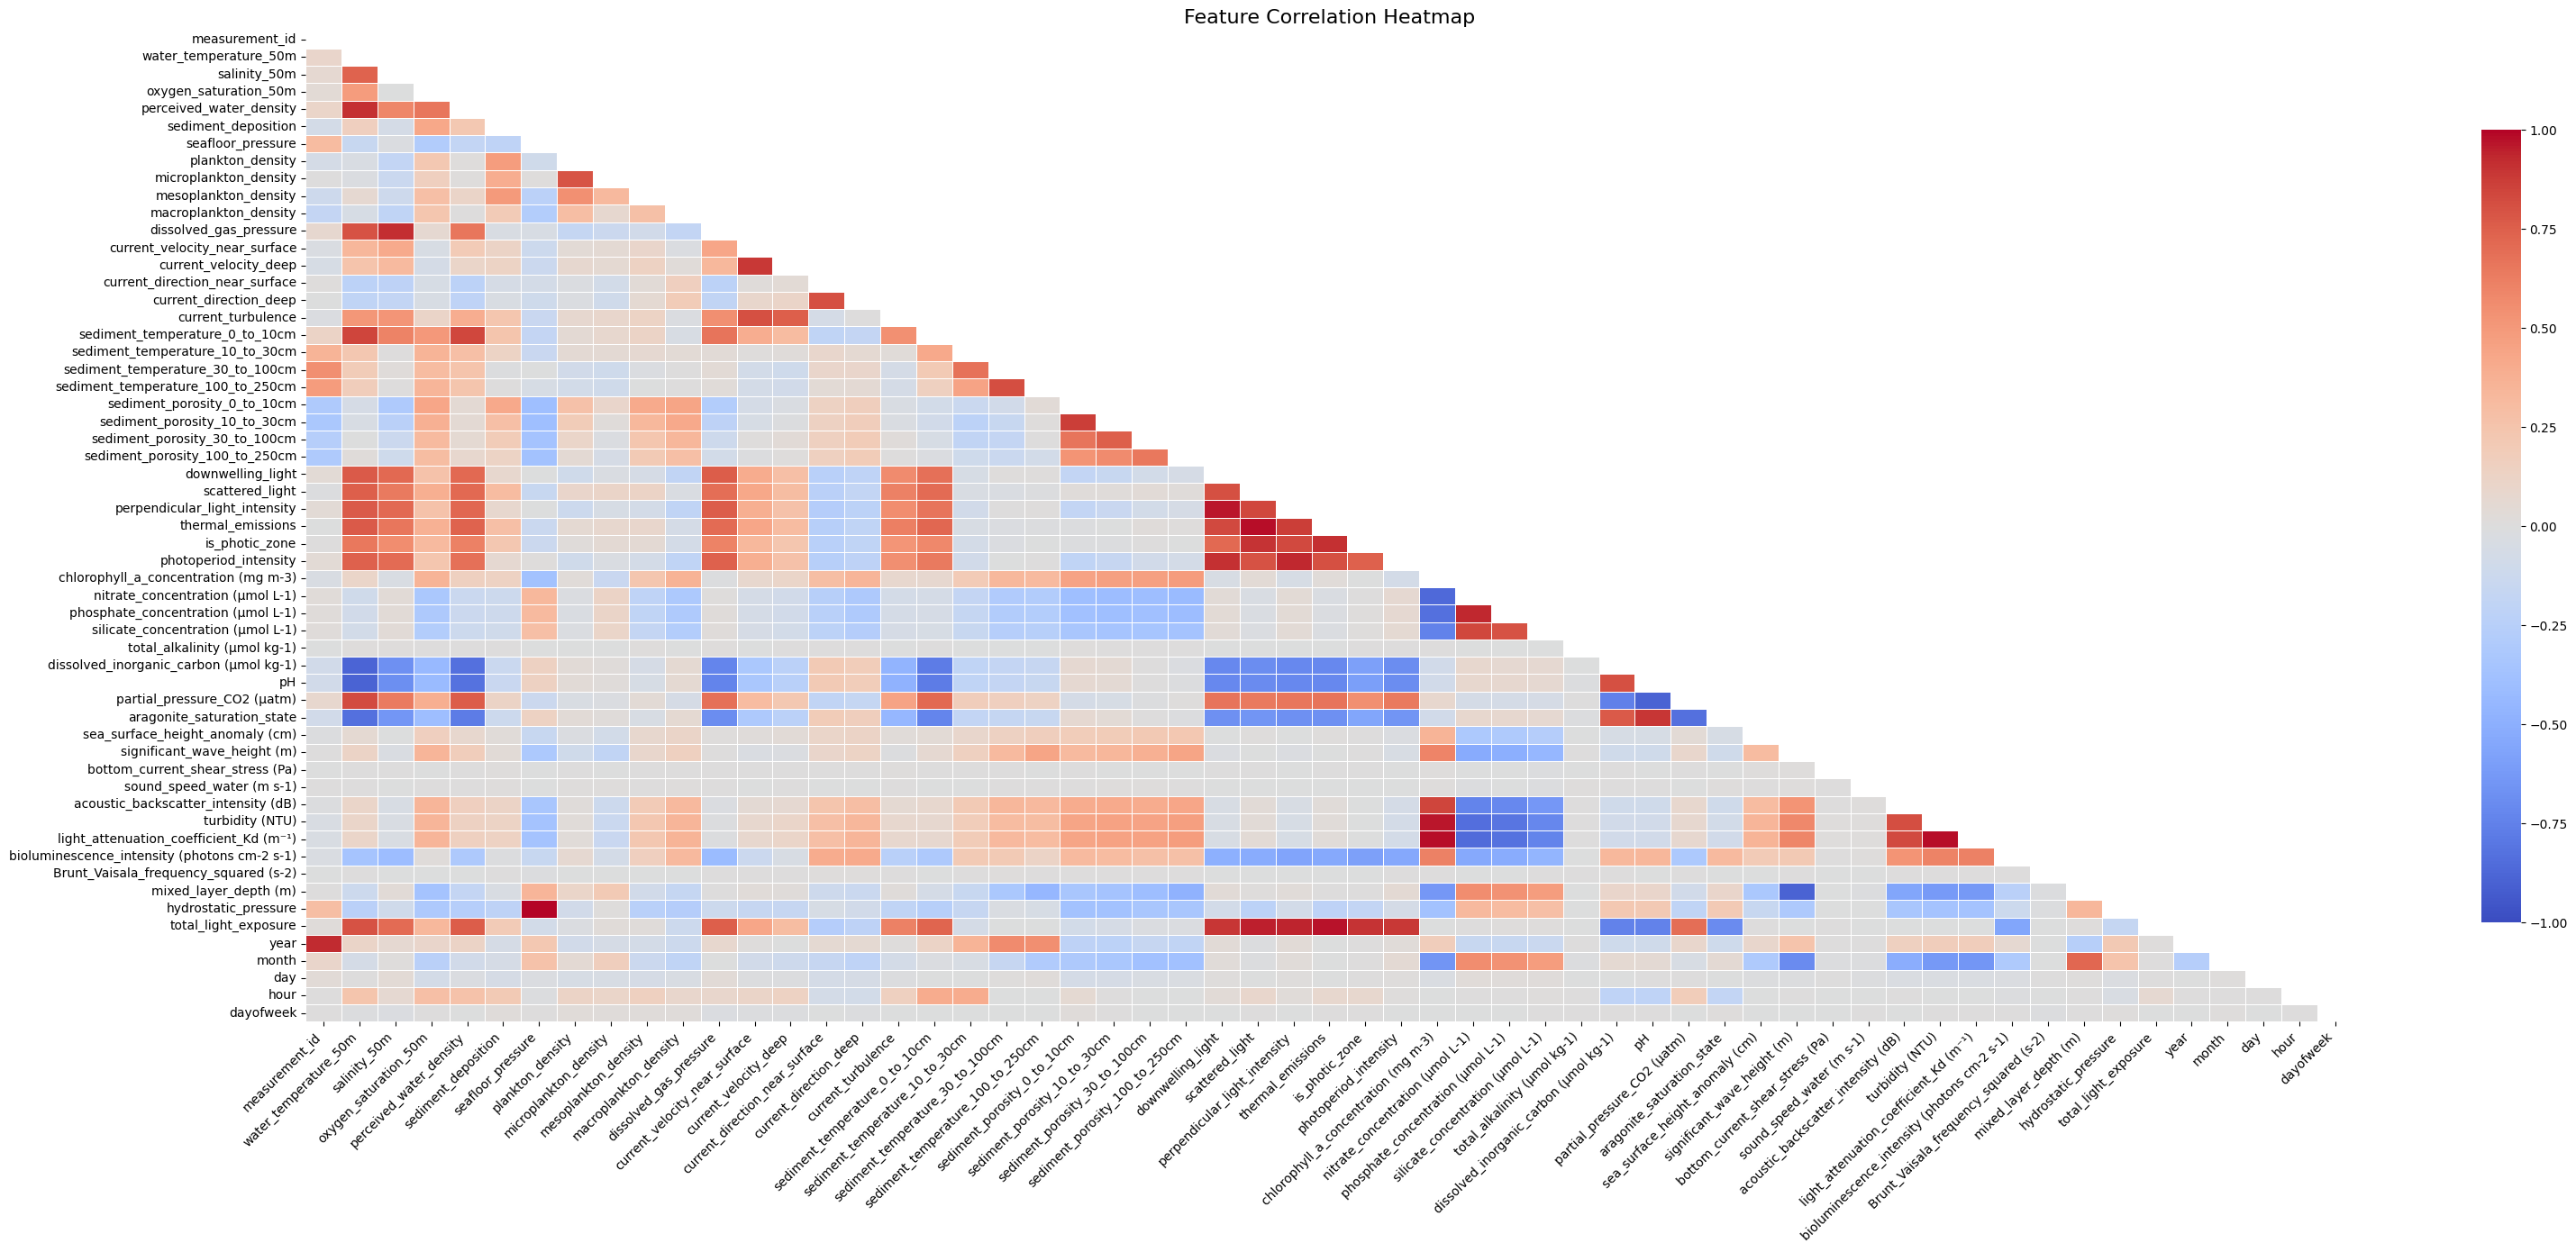

In [6]:
plt.figure(figsize=(32, 14))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

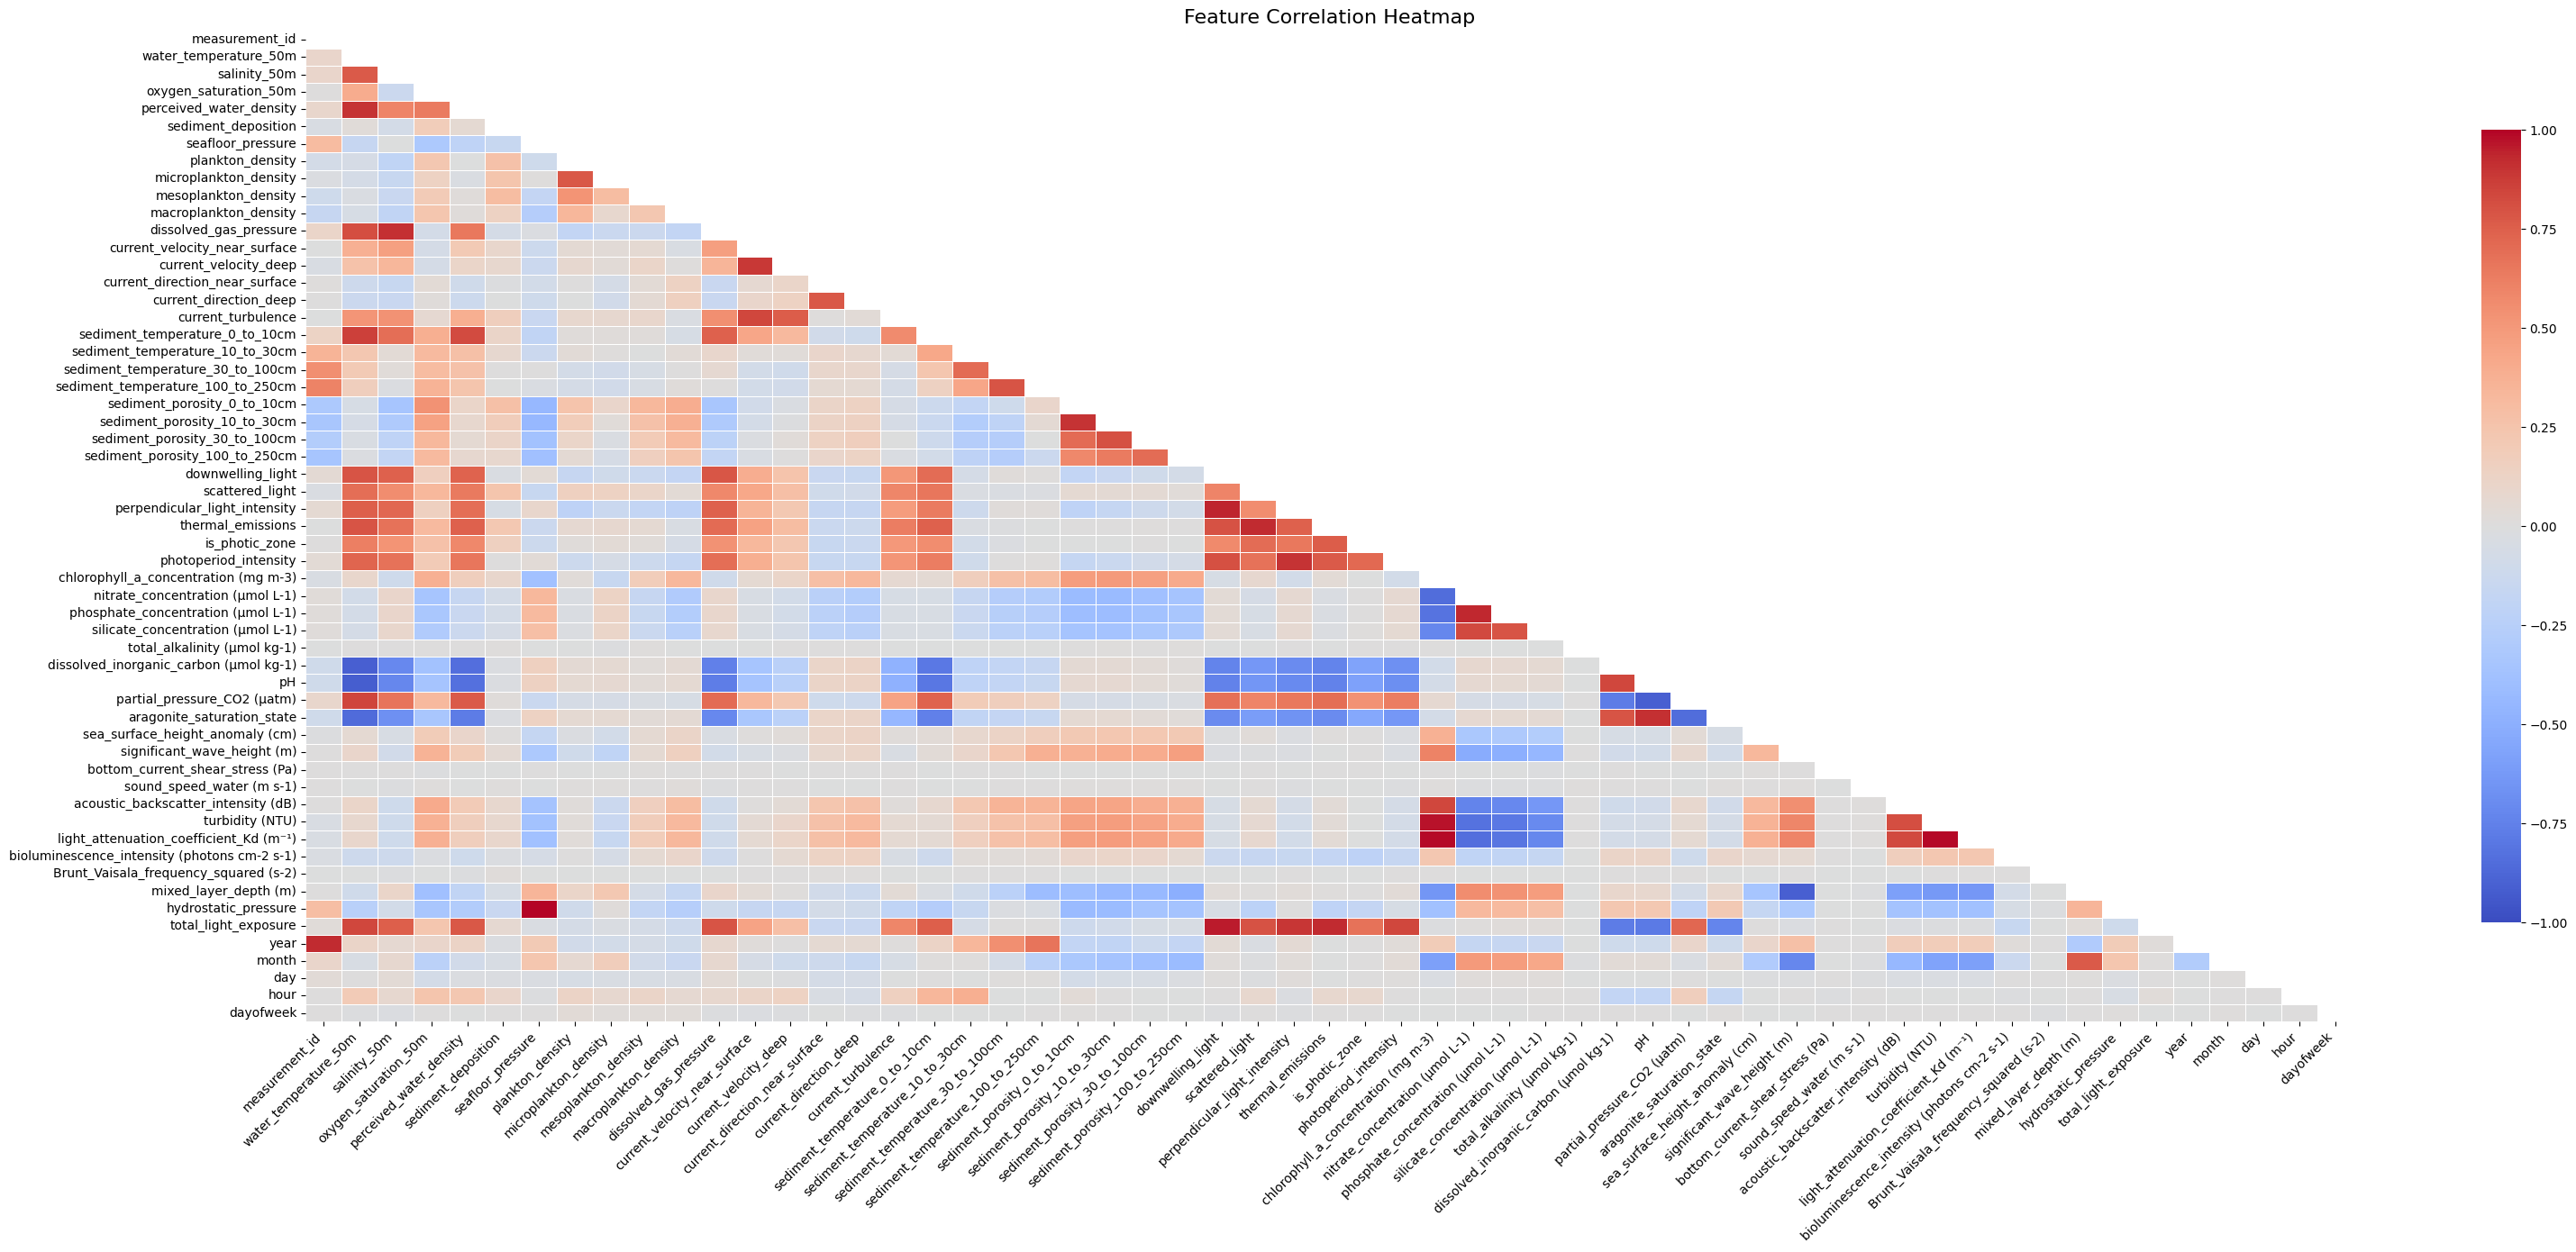

In [7]:
# Convert date column to datetime
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'])

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(32, 14))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
def impute_features_knn(df, features_to_impute, n_neighbors=5, verbose=True):
    """
    Mengimputasi nilai yang hilang dalam fitur-fitur tertentu dari DataFrame menggunakan KNNImputer.

    Args:
        df (pd.DataFrame): DataFrame input yang mungkin mengandung nilai NaN.
        features_to_impute (list): Daftar string nama kolom yang akan diimputasi.
        n_neighbors (int): Jumlah tetangga yang akan digunakan oleh KNNImputer.
        verbose (bool): Jika True, akan mencetak informasi proses dan perbandingan.

    Returns:
        pd.DataFrame: DataFrame dengan nilai yang telah diimputasi pada fitur yang ditentukan.
                      Perubahan dilakukan inplace pada DataFrame asli yang dilewatkan.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' harus berupa pandas DataFrame.")
    if not isinstance(features_to_impute, list) or not all(isinstance(f, str) for f in features_to_impute):
        raise TypeError("'features_to_impute' harus berupa list string.")
    if not isinstance(n_neighbors, int) or n_neighbors < 1:
        raise ValueError("'n_neighbors' harus berupa integer positif.")

    # Pastikan kolom-kolom ini ada di DataFrame
    valid_features = [col for col in features_to_impute if col in df.columns]
    missing_cols_in_df = [col for col in features_to_impute if col not in df.columns]

    if missing_cols_in_df and verbose:
        print(f"Peringatan: Kolom berikut tidak ditemukan di DataFrame dan akan dilewati: {missing_cols_in_df}")

    if not valid_features:
        if verbose:
            print("Tidak ada fitur valid yang ditemukan di DataFrame untuk diimputasi. Mengembalikan DataFrame asli.")
        return df

    # Buat subset DataFrame hanya dengan fitur yang akan diimputasi
    # dan simpan indeks aslinya
    df_subset = df[valid_features].copy()
    original_index = df_subset.index

    # Simpan kondisi NaN awal untuk perbandingan
    nan_mask_original = df_subset.isnull()

    if verbose:
        print("Nilai yang hilang SEBELUM imputasi KNN:")
        missing_before = df_subset.isnull().sum()
        print(missing_before[missing_before > 0])
        print("-" * 30)

    # Hanya lanjutkan jika ada missing values
    if df_subset.isnull().any().any():
        # 1. Scaling
        scaler = StandardScaler()
        # Simpan nama kolom sebelum scaling
        scaled_columns = df_subset.columns
        # Hindari warning DataConversionWarning jika semua kolom adalah integer
        df_scaled_array = scaler.fit_transform(df_subset.astype(float))
        df_scaled = pd.DataFrame(df_scaled_array, columns=scaled_columns, index=original_index)

        # 2. Imputasi menggunakan KNNImputer
        n_samples = len(df_scaled)
        # Pastikan n_neighbors tidak lebih besar dari jumlah sampel non-NaN yang tersedia.
        # Jika jumlah baris sangat sedikit, kurangi n_neighbors.
        # k_neighbors_actual harus minimal 1
        k_neighbors_actual = min(n_neighbors, n_samples - 1 if n_samples > 1 else 1)
        if k_neighbors_actual == 0 and n_samples == 1: # Kasus jika hanya ada 1 baris
             k_neighbors_actual = 1
        
        if k_neighbors_actual < 1: # Safety net, jika n_samples = 0 atau 1 dan n_neighbors > 0
            if verbose:
                print(f"Tidak cukup sampel ({n_samples}) untuk imputasi KNN dengan k > 0. Melewati imputasi.")
            return df


        if verbose and k_neighbors_actual != n_neighbors:
            print(f"Peringatan: n_neighbors disesuaikan dari {n_neighbors} menjadi {k_neighbors_actual} karena jumlah sampel ({n_samples}).")

        imputer = KNNImputer(n_neighbors=k_neighbors_actual)

        # Imputer akan mengembalikan numpy array
        df_imputed_scaled_array = imputer.fit_transform(df_scaled)

        # Konversi kembali ke DataFrame
        df_imputed_scaled = pd.DataFrame(df_imputed_scaled_array, columns=scaled_columns, index=original_index)

        # 3. Kembalikan ke skala semula (inverse transform)
        df_imputed_original_scale_array = scaler.inverse_transform(df_imputed_scaled)
        df_imputed_original_scale = pd.DataFrame(df_imputed_original_scale_array, columns=scaled_columns, index=original_index)

        # 4. Gabungkan kembali nilai yang sudah diimputasi ke DataFrame df utama
        # Pastikan tipe data setelah imputasi sesuai dengan tipe data kolom asli jika memungkinkan
        for col in valid_features:
            original_dtype = df[col].dtype
            imputed_values = df_imputed_original_scale[col]
            try:
                # Coba konversi kembali ke tipe data asli, terutama untuk integer
                if pd.api.types.is_integer_dtype(original_dtype) and not pd.api.types.is_bool_dtype(original_dtype):
                     # Cek apakah semua nilai yang diimputasi bisa jadi integer tanpa kehilangan informasi
                    if np.all(np.mod(imputed_values.dropna(), 1) == 0):
                        imputed_values = imputed_values.astype(int)
                    else:
                        if verbose:
                            print(f"Peringatan: Kolom '{col}' bertipe integer, namun nilai imputasi memiliki desimal. Dibiarkan sebagai float.")
                elif pd.api.types.is_float_dtype(original_dtype):
                    imputed_values = imputed_values.astype(float)
                # Tambahkan penanganan tipe data lain jika perlu
            except Exception as e:
                if verbose:
                    print(f"Peringatan: Gagal mengkonversi kolom '{col}' kembali ke tipe asli {original_dtype}: {e}")
            
            df.loc[original_index, col] = imputed_values


        if verbose:
            print("\nNilai yang hilang SETELAH imputasi KNN:")
            missing_after = df[valid_features].isnull().sum()
            print(missing_after[missing_after > 0]) # Harusnya kosong jika semua terimputasi
            if not missing_after[missing_after > 0].empty:
                 print("Peringatan: Masih ada nilai yang hilang setelah imputasi. Ini bisa terjadi jika seluruh baris adalah NaN atau k terlalu kecil/besar untuk data.")
            print("-" * 30)

            # --- TAMPILKAN PERBANDINGAN ---
            print("Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi):")
            any_imputed_values_shown = False
            for feature in valid_features:
                # Dapatkan indeks dari df_subset (original_index) di mana fitur ini awalnya NaN
                idx_nan_in_feature = nan_mask_original[nan_mask_original[feature]].index

                if not idx_nan_in_feature.empty:
                    any_imputed_values_shown = True
                    if verbose:
                        print(f"\n--- Fitur: {feature} ---")
                    # Nilai sebelum diambil dari salinan yang kita buat (df_subset sebelum modifikasi inplace)
                    before_values = df_subset.loc[idx_nan_in_feature, feature]
                    # Nilai sesudah diambil dari df utama yang sudah diupdate
                    after_values = df.loc[idx_nan_in_feature, feature]

                    comparison_df = pd.DataFrame({
                        'Indeks Asli': idx_nan_in_feature,
                        'Sebelum': before_values,
                        'Sesudah': after_values.round(4) # Pembulatan untuk tampilan
                    }).set_index('Indeks Asli')
                    if verbose:
                        print(comparison_df)
            if not any_imputed_values_shown and verbose:
                print("Tidak ada nilai spesifik yang teridentifikasi telah diimputasi (mungkin tidak ada NaN awal pada fitur yang dipilih).")

    elif verbose:
        print("Tidak ada nilai yang hilang pada fitur yang dipilih untuk diimputasi.")
    
    return df

In [9]:
features = ['sediment_temperature_0_to_10cm',
            'sediment_temperature_10_to_30cm',
            'sediment_temperature_30_to_100cm', 
            'sediment_temperature_100_to_250cm'
        ]

In [10]:
df_imputed = impute_features_knn(df, features, n_neighbors=5, verbose=True)

Nilai yang hilang SEBELUM imputasi KNN:
sediment_temperature_10_to_30cm      3088
sediment_temperature_30_to_100cm     1591
sediment_temperature_100_to_250cm    3839
dtype: int64
------------------------------

Nilai yang hilang SETELAH imputasi KNN:
Series([], dtype: int64)
------------------------------
Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi):

--- Fitur: sediment_temperature_10_to_30cm ---
             Sebelum  Sesudah
Indeks Asli                  
0                NaN   298.21
15               NaN   298.77
19               NaN   299.69
22               NaN   298.93
27               NaN   298.33
...              ...      ...
21870            NaN   298.21
21877            NaN   299.03
21878            NaN   299.13
21881            NaN   299.11
21887            NaN   299.33

[3088 rows x 2 columns]

--- Fitur: sediment_temperature_30_to_100cm ---
             Sebelum  Sesudah
Indeks Asli                  
8                NaN   298.35
53            

In [13]:
df.to_csv('data/fitur_clean/temp.csv', index=False)